## Problem Statement 

To build a model that is able to classify customer complaints based on the products/services. It will help[ to segregate the tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

Uisng Topic Modelling and NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 

After mapping each ticket onto its respective department/category, the data can be used by supervised model such as logistic regression, decision tree or random forest for training. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

To perform below major tasks for the assignment:

1.  Data loading (.json data)

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
file = 'C://Users//prapt//OneDrive//Desktop//Data Science Journey//python code//NLP Specialisation//Ticket Classification Case Study//complaints-2021-05-14_08_16.json'
# returns JSON object as a dictionary 

with open(file, "r") as f:
    data = json.load(f)
data_df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

print(data_df.shape) ## There are 78313 compliants and 22 features.
data_df.head()


(78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
## To check if there are any duplicate entries.
print('Total number of unique records :',len(data_df['_id'].unique()))

## All records are unique as there are 78313 unique compliant id which is matching with total rows in dataframe.

Total number of unique records : 78313


In [5]:
#print the column names
cols_name = list(data_df.columns)
print('Columns in Data :\n',cols_name)

Columns in Data :
 ['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [6]:
#Assign new column names as follows:-

## To remove '_' at begining of column name.

data_df.rename(columns= lambda x: x.lstrip('_'), inplace=True)

## To replace '.' with '_' as '.' can create problem when used further in pandas.

data_df.rename(columns= lambda x: x.replace('.','_'), inplace=True)

## Remove 'source' at begining from all column name as it is common to all and does not add any value.

data_df.rename(columns= lambda x: x.replace('source_',''), inplace=True)

## Amending column name 'complaint_what_happened' to 'complaints' to keep it simple.

data_df.rename(columns= lambda x: x.replace('complaint_what_happened','complaints'), inplace=True)

## Checking columns names after making changes.
print('Column name after making changes :\n',data_df.columns)

Column name after making changes :
 Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely', 'complaints',
       'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [7]:
## Checking number of Blanks in 'complaints' column.

print("Total number of 'Blanks' in 'Complaints' columns :",(data_df['complaints']=='').sum())  ## There are total 57241 blanks in 'complaints' column.

#Assign nan in place of blanks in the complaints column.

data_df['complaints']=data_df['complaints'].replace('',np.nan)

Total number of 'Blanks' in 'Complaints' columns : 57241


In [8]:
## Checking there are no blanks in 'complaints'
(data_df['complaints']=='').sum()

0

In [9]:
#Remove all rows where complaints column is nan
data_df=data_df[~data_df['complaints'].isna()]

In [10]:
## Checking dtaaframe after removing rows with NaN values in complaints column.
data_df.shape 
## There are 21072 rows.
data_df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [11]:
## Reseting index

data_df.reset_index(drop=True,inplace=True)

## Prepare the text for topic modeling

To perform below steps as part of text pre-processing:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


After cleaning text, need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.

def text_preprocess(cols):
    ## To lowercase text
    cols_new= [cols[i].lower() for i in range(len(cols))]
    ## To remove words in square brackets
    cols_new= [re.sub(r'\[.*?\]','',sent)  for sent in cols_new]
    ## To remove punctuations
    cols_new= [re.sub(r'[^A-Za-z0-9\s]','',sent)  for sent in cols_new]
    ## To remove words containing numbers
    cols_new= [re.sub(r'\b\w*\d\w*\b','',sent)  for sent in cols_new]
    return cols_new
    
data_df['complaints']=text_preprocess(data_df['complaints'])


In [13]:
## Checking few samples.
data_df['complaints'][8]

'on xxxx  i made a  payment to an online retailer using chase quick pay with xxxx on the chase website i realized that this was a scam website after no confirmation product or response to any inquiries regarding the order and contacted chase to get more information about the transaction to attempt getting a refund through the retailers bank \n\ni contacted chase via a secured message on  explaining what happened and asked  is there a way to reverse this transaction or do you have a contact at xxxx that can give me more information about the recipient  that xxxx my message was reviewed and i received a response restating my original email and informing me that  the transfer has been completed however as you mentioned that the website is a scam while we can handle most inquiries by email some require the expertise of another team in order to assist you better in regards to the refund we request you to call our consumer online technical support team  i called the number listed in the emai

In [14]:
#Write your function to Lemmatize the texts

def sent_lemmatize(sent):
    ## Creating tokens of sentence.
    doc = nlp(sent)
    token=[]
    for word in doc:
        token.append(word)
    ## Lemmatizing tokenized words.
    return(' '.join([wrd.lemma_ for wrd in token]))
import time
start_time=time.time()
##Calling above defined function to lemmatize each complaints text.
lemmatize=[]
for num in range(len(data_df['complaints'])):
    lemmatize.append(sent_lemmatize(data_df['complaints'][num]))
end_time=time.time()
print(end_time - start_time)

656.8398530483246


In [15]:
## It took around 11 mins to lemmatize all complaints data.

## Checking one sample of actual complaint data and its lematized text.
print('Complaint text sample:-\n',data_df['complaints'][2])
print('Lemmatized complaints sampple :-\n',lemmatize[2])

Complaint text sample:-
 chase card was reported on  however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
Lemmatized complaints sampple :-
 chase card be report on   however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant


In [16]:
## Adding lemmatized complints as new column in actual dataframe.

data_df['lemmatized_complaint']=lemmatize
data_df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided,lemmatized_complaint
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name be xxxx xxxx and I apprec...
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided,I upgrade my xxxx xxxx card in and be tell b...
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent...,Information belongs to someone else,Consent provided,chase card be report on however fraudulent a...
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket ...,Information belongs to someone else,Consent provided,on while try to book a xxxx xxxx ticket ...
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided,my grand son give I check for I deposit it i...


In [17]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=data_df[['complaints','lemmatized_complaint']]

In [18]:
df_clean

,complaints,lemmatized_complaint
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [19]:
#Write your function to extract the POS tags 

def pos_tag(sent):
      # write your code here
    noun_pos=[]
    for tok in nlp(sent):
        if tok.tag_ == 'NN':   ## Chekcing for NN tags.
            noun_pos.append(tok.text)
    return(' '.join([wrd for wrd in noun_pos]))
        
pos_removed=[]
start_time=time.time()
# ##Calling above defined function to extract only Noun pos tag of each complaints text.
for num in range(len(df_clean['lemmatized_complaint'])):
    pos_removed.append(pos_tag(df_clean['lemmatized_complaint'][num]))
end_time=time.time()
print(end_time-start_time)


644.2849957942963


In [20]:
## It took around 12 mins to complete pos tag extraction.

#'complaint_POS_removed' column contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  pos_removed 


In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaints,lemmatized_complaint,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




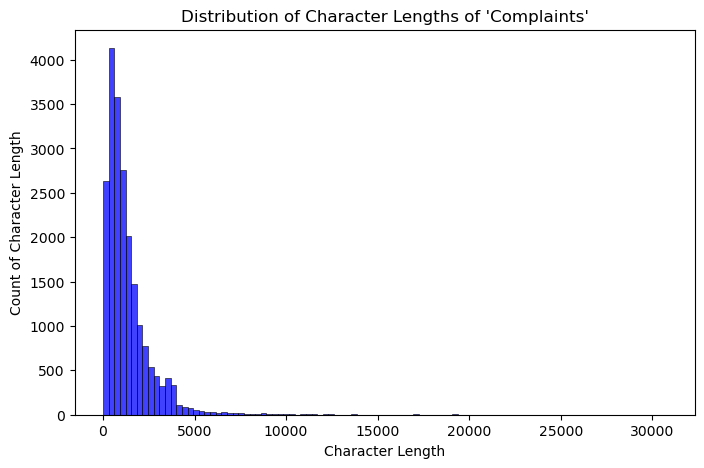

In [22]:
# Write your code here to visualise the data according to the 'Complaint' character length

## Creating a column that contains character length of each complaints.
df_clean['char_length'] = df_clean['complaints'].apply(len)
df_clean.head()

## Using histohgram for plotting of character length to visualize character length distribution.

plt.figure(figsize=(8, 5))
sns.histplot(df_clean['char_length'], bins=100, color='blue')
plt.xlabel("Character Length")
plt.ylabel("Count of Character Length")
plt.title("Distribution of Character Lengths of 'Complaints'")
plt.show()

#### Observation:- Maximum distribution of character length is in range from 0 to 5000. Also, most frequently occuring records are having character length 4200.

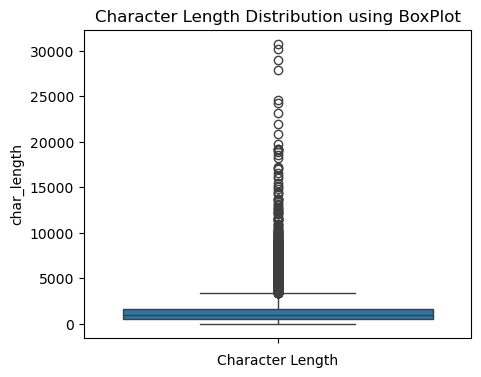

In [23]:
## Plotting Box-plot to check if there are any outliers.

plt.figure(figsize=(5, 4))
sns.boxplot(df_clean['char_length'])
plt.xlabel("Character Length")
plt.title("Character Length Distribution using BoxPlot")
plt.show()

#### Observation: From above plot we can comnclude that there are many complaints which is very long (length more than 15000).

In [24]:
print(df_clean[df_clean['char_length']>15000].shape) ## Theer are total 26 such compliants that have total character length greater than 15000.

(26, 4)


In [25]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [26]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [27]:
#All masked texts has been removed
df_clean['Complaint_clean'][0:10]

0    morning name stop service debt verification st...
1    card agent anniversary date agent information ...
2    chase card report application identity consent...
3    ticket offer ticket reward card information of...
4    son chase account fund chase bank account mone...
5                                              inquiry
6    notice account debit card branch customer serv...
7    summer month decline income employment month p...
8    payment retailer use chase pay chase website s...
9    chase credit card report datum credit report c...
Name: Complaint_clean, dtype: object

#### Find the top 40 words by frequency among all the articles after processing the text.

In [28]:
## importing required libraries for word cloud.

!pip install wordcloud
from wordcloud import WordCloud
from collections import Counter

## stopwords for preporocessing
stop_words = nlp.Defaults.stop_words


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
#Using word cloud to find the top 40 words by frequency among all the articles after processing the text

## Function to preprocess text.
def pre_process_word_cloud(sent):
    return(' '.join([wrd for wrd in sent.split() if wrd.lower() not in stop_words]))
    
word_cloud_preprocess = df_clean['Complaint_clean'].apply(pre_process_word_cloud)
all_text =' '.join(word_cloud_preprocess)

## To count frequence of word.
text_freq = Counter(all_text.split())

In [30]:
top_freq_words = dict(text_freq.most_common(40))
top_freq_words

{'chase': 60184,
 'account': 47225,
 'credit': 33489,
 'card': 30272,
 'bank': 21616,
 'payment': 21152,
 'time': 16011,
 'charge': 14743,
 'day': 12941,
 'money': 11929,
 'check': 11579,
 'loan': 10818,
 'information': 9638,
 'letter': 9596,
 'fee': 8850,
 'report': 8774,
 'transaction': 8595,
 'number': 8591,
 'month': 8466,
 'year': 8289,
 'customer': 8126,
 'mortgage': 7989,
 'balance': 7755,
 'service': 7712,
 'phone': 7582,
 'company': 7547,
 'claim': 7279,
 'fund': 7031,
 'state': 6720,
 'fraud': 6586,
 'issue': 6506,
 'email': 6054,
 'date': 6012,
 'dispute': 5824,
 'business': 5509,
 'request': 5275,
 'interest': 5252,
 'statement': 5239,
 'deposit': 4990,
 'complaint': 4926}

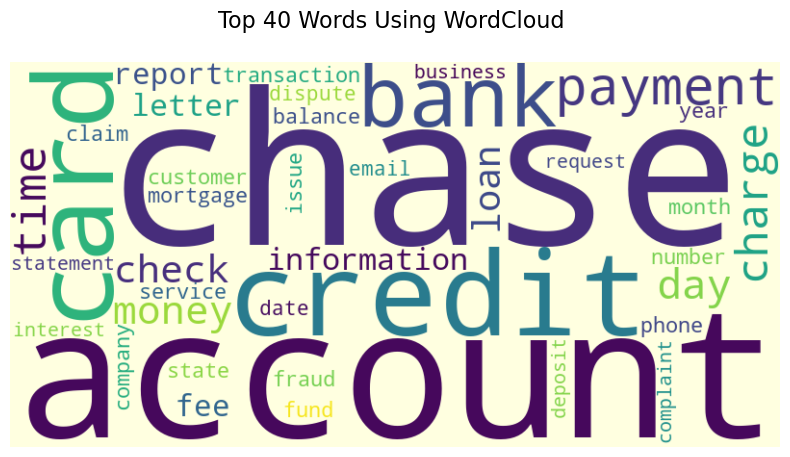

In [31]:
# Creating Word Cloud
wrdcld = WordCloud(width=800, height=400, background_color='lightyellow', colormap='viridis').generate_from_frequencies(top_freq_words)

# Visualize the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wrdcld, interpolation='bilinear')
plt.axis("off")
plt.title("Top 40 Words Using WordCloud \n", fontsize=16)
plt.show()

#### Observation : 'Chase' is word thats occurs very frequently followed by 'account', 'card', 'credit', 'payment'.

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [32]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

## Function to preprocess text.
def pre_process(sent):
    return(' '.join([wrd for wrd in sent.split() if wrd.lower() not in stop_words]))
    
word_preprocess = df_clean['Complaint_clean'].apply(pre_process)
all_text =' '.join(word_preprocess)

## To count frequence of word.
text_freq = Counter(all_text.split())
## Top 30 unigram frequency(single word).
top_30_unigram_words = dict(text_freq.most_common(30))
print('Top 30 unigram frequency:-\n\n',top_30_unigram_words)

Top 30 unigram frequency:-

 {'chase': 60184, 'account': 47225, 'credit': 33489, 'card': 30272, 'bank': 21616, 'payment': 21152, 'time': 16011, 'charge': 14743, 'day': 12941, 'money': 11929, 'check': 11579, 'loan': 10818, 'information': 9638, 'letter': 9596, 'fee': 8850, 'report': 8774, 'transaction': 8595, 'number': 8591, 'month': 8466, 'year': 8289, 'customer': 8126, 'mortgage': 7989, 'balance': 7755, 'service': 7712, 'phone': 7582, 'company': 7547, 'claim': 7279, 'fund': 7031, 'state': 6720, 'fraud': 6586}


In [33]:
#Print the top 10 words in the unigram frequency
print('Top 10 words in the unigram frequency:-\n',list(top_30_unigram_words)[0:10])

Top 10 words in the unigram frequency:-
 ['chase', 'account', 'credit', 'card', 'bank', 'payment', 'time', 'charge', 'day', 'money']


In [34]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

## Function to preprocess text.
def pre_process_word(sent):
    sent_nlp = nlp(semt.lower())
    tok = [wrd.text for wrd in sent_nlp if not wrd.is_stop]
    return tok
    
word_preprocess = df_clean['Complaint_clean'].apply(pre_process_word_cloud)
all_word = ' '.join(word_preprocess).split()

## To create Bi-Gram(pair of words) of above preprocessed words.
wrd_bigram = [(all_word[i], all_word[i + 1]) for i in range(len(all_word) - 1)]

## To find top 30 bigram frequncy.

wrd_bigram_freq = Counter(wrd_bigram)
wrd_bigram_top_30 = dict(wrd_bigram_freq.most_common(30))

print('Top 30 frequent bigram from complaints:-\n\n',wrd_bigram_top_30)


Top 30 frequent bigram from complaints:-

 {('credit', 'card'): 12850, ('chase', 'bank'): 4021, ('credit', 'report'): 3955, ('account', 'chase'): 3728, ('chase', 'credit'): 3240, ('customer', 'service'): 3067, ('chase', 'account'): 2911, ('account', 'account'): 2530, ('bank', 'account'): 2479, ('checking', 'account'): 2423, ('debit', 'card'): 2003, ('card', 'chase'): 1883, ('chase', 'card'): 1853, ('card', 'account'): 1722, ('check', 'account'): 1722, ('credit', 'score'): 1713, ('account', 'credit'): 1606, ('payment', 'payment'): 1551, ('chase', 'chase'): 1379, ('chase', 'customer'): 1341, ('money', 'account'): 1327, ('account', 'bank'): 1318, ('interest', 'rate'): 1290, ('phone', 'number'): 1263, ('business', 'day'): 1228, ('payment', 'chase'): 1187, ('account', 'number'): 1151, ('charge', 'chase'): 1151, ('charge', 'account'): 1149, ('card', 'company'): 1136}


In [35]:
#Print the top 10 words in the bigram frequency

print('Top 10 words in the bigram frequency:-\n')
list(wrd_bigram_top_30)[0:10]

Top 10 words in the bigram frequency:-



[('credit', 'card'),
 ('chase', 'bank'),
 ('credit', 'report'),
 ('account', 'chase'),
 ('chase', 'credit'),
 ('customer', 'service'),
 ('chase', 'account'),
 ('account', 'account'),
 ('bank', 'account'),
 ('checking', 'account')]

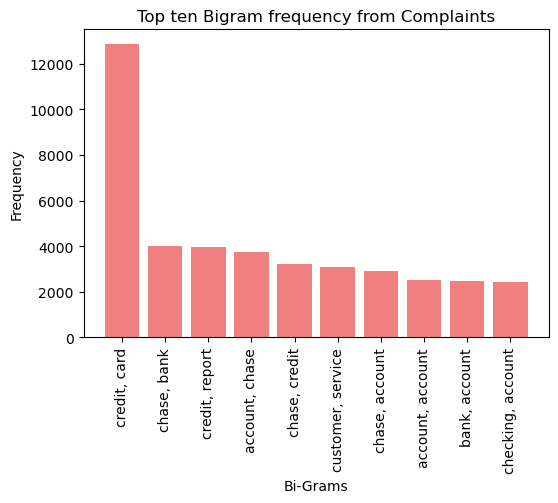

In [36]:
## Plot of Top 10 Bigram frequency to visualize dsitribution.

values=list(wrd_bigram_top_30.values())[0:10]    ## Extracting frequency values in list.
keys=[', '.join(val) for val in list(wrd_bigram_top_30.keys())[0:10]]   ## Extracting bi-gram term in a list.

plt.figure(figsize=(6, 4))
plt.bar(keys, values, color='lightcoral')
plt.xticks(rotation=90)
plt.xlabel('Bi-Grams')
plt.ylabel('Frequency')
plt.title('Top ten Bigram frequency from Complaints')
plt.show()

**Findings :- Credit Card seems to be highly used Bi-gram term in complaint dataset.**

In [37]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

## To create tri-Gram(pair of words) from preprocessed words.
wrd_trigram = [(all_word[i], all_word[i + 1],all_word[i+2]) for i in range(len(all_word) - 2)]

## To find top 30 trigram frequncy.

wrd_trigram_freq = Counter(wrd_trigram)
wrd_trigram_top_30 = dict(wrd_trigram_freq.most_common(30))

print('Top 30 frequent trigram from complaints:-\n\n',wrd_trigram_top_30)


Top 30 frequent trigram from complaints:-

 {('chase', 'credit', 'card'): 2198, ('credit', 'card', 'account'): 1106, ('credit', 'card', 'company'): 996, ('credit', 'card', 'chase'): 857, ('chase', 'customer', 'service'): 619, ('credit', 'card', 'credit'): 529, ('inquiry', 'credit', 'report'): 518, ('account', 'credit', 'card'): 483, ('chase', 'bank', 'account'): 441, ('charge', 'credit', 'card'): 438, ('card', 'credit', 'card'): 429, ('credit', 'report', 'credit'): 377, ('chase', 'check', 'account'): 374, ('credit', 'reporting', 'agency'): 370, ('customer', 'service', 'representative'): 348, ('credit', 'reporting', 'act'): 338, ('account', 'chase', 'bank'): 328, ('account', 'chase', 'account'): 326, ('credit', 'card', 'charge'): 314, ('credit', 'card', 'payment'): 311, ('credit', 'report', 'chase'): 307, ('account', 'credit', 'report'): 300, ('checking', 'account', 'chase'): 291, ('bank', 'credit', 'card'): 283, ('credit', 'card', 'balance'): 268, ('credit', 'card', 'card'): 263, ('vic

In [38]:
#Print the top 10 words in the trigram frequency

print('Top 10 words in the trigram frequency:-')
list(wrd_trigram_top_30)[0:10]

Top 10 words in the trigram frequency:-


[('chase', 'credit', 'card'),
 ('credit', 'card', 'account'),
 ('credit', 'card', 'company'),
 ('credit', 'card', 'chase'),
 ('chase', 'customer', 'service'),
 ('credit', 'card', 'credit'),
 ('inquiry', 'credit', 'report'),
 ('account', 'credit', 'card'),
 ('chase', 'bank', 'account'),
 ('charge', 'credit', 'card')]

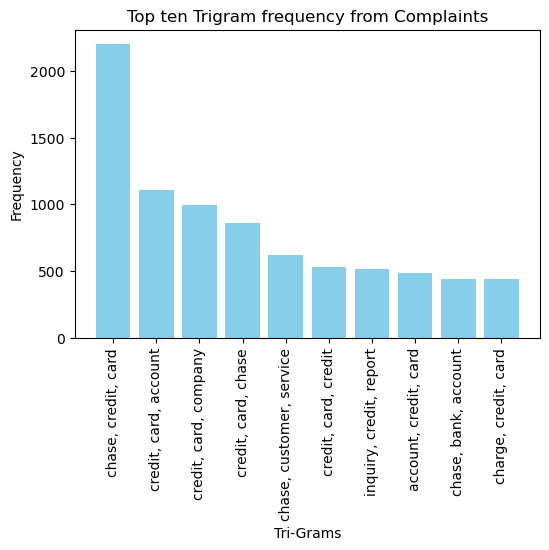

In [39]:
## Plot of Top 10 Trigram frequency to visualize dsitribution.

values=list(wrd_trigram_top_30.values())[0:10]    ## Extracting frequency values in list.
keys=[', '.join(val) for val in list(wrd_trigram_top_30.keys())[0:10]]   ## Extracting bi-gram term in a list.

plt.figure(figsize=(6, 4))
plt.bar(keys, values, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Tri-Grams')
plt.ylabel('Frequency')
plt.title('Top ten Trigram frequency from Complaints')
plt.show()

**Findings :- 'Chase Credit Card' seems to be highly used Trigram term in complaint dataset.**

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [40]:
#Write your code here to initialise the TfidfVectorizer 

tfidf_vectorize = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2) 

## stop_words is used to remove English stop words from data, max_df is 95% which means it will ignore words that appear more than 95% of documents \
## and min_df is 2 whcih means words that appear less than 2 documnets are ingored.


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [41]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

## Creating document list.
doc = list(df_clean['Complaint_clean'])

# To create TF-IDF matrix of document.
tfidf = tfidf_vectorize.fit_transform(doc)

In [42]:
## Cretaing dataframe of tfidf 2matrix.

tfidf_df = pd.DataFrame(tfidf.toarray())

## Extracting feature names.

cols = tfidf_vectorize.get_feature_names_out()

tfidf_df.columns=cols


In [43]:
## To analyse tfidf matrix.
tfidf_df

,aarp,ab,abandonment,abatement,abbreviation,abet,abide,ability,abovementione,abovereference,...,yoga,youinv,youth,yr,yrs,zap,zip,zipcode,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***We have total 6767 unique vocabulary in complaints data.***

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [44]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [45]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)  #write your code here

In [46]:
##Generating Doc-Topic matrix and Topic-Term matrix using NMF.

W = nmf_model.fit_transform(tfidf)  ## W is Doc-topic matirx
H = nmf_model.components_           ## H is topic-term matirx

## W matrix is of dimension 21072 X 5 and H matrix is of dimension 5 X 6767
print('Rows and Column of W matrix: ',np.shape(W))
print('Rows and Column of H matrix: ',np.shape(H))


Rows and Column of W matrix:  (21072, 5)
Rows and Column of H matrix:  (5, 6767)


In [47]:
##Listing out top 15 words(based on highest value) of each topic row .

word=np.zeros((5,15)).astype('str')

cols=tfidf_vectorize.get_feature_names_out()
for i in range(0,num_topics):
        word[i]=(cols[np.argsort(H[i])[::-1]][:15])

## Creating dataframe of top 15 words of each topic.

pd.DataFrame(word,index=[ f'Topic{i+1}' for i in range(0,num_topics)] , \
                columns=[f'Word{i+1}' for i in range(0,15)])

,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15
Topic1,account,check,bank,money,chase,fund,deposit,branch,day,checking,number,business,transaction,transfer,customer
Topic2,credit,card,report,inquiry,chase,account,score,company,debt,limit,information,application,letter,year,reporting
Topic3,loan,mortgage,chase,home,modification,property,year,letter,document,rate,time,foreclosure,house,sale,request
Topic4,charge,card,chase,fee,transaction,dispute,purchase,merchant,fraud,claim,service,time,statement,email,refund
Topic5,payment,balance,month,fee,statement,day,time,auto,chase,date,credit,account,mortgage,year,error


**From above model using 5 component number does not give clear categories of topics. Increasing number of topics in next model.**

In [48]:
## Increasing topic_number to 8 to check for more topics.
num_topics1 = 8

#keep the random_state =40
nmf_model1 = NMF(n_components=num_topics1, random_state=40)  

## Decomposing doc-term matrix usng NMF.
W1 = nmf_model1.fit_transform(tfidf)  ## W is Doc-topic matirx
H1 = nmf_model1.components_           ## H is topic-term matirx

## W matrix is of dimension 21072 X 8 and H matrix is of dimension 8 X 6767
print('Rows and Column of W matrix: ',np.shape(W1))
print('Rows and Column of H matrix: ',np.shape(H1))

##Listing out top 20 words(based on highest value) of each topic row .

word1=np.zeros((8,20)).astype('str')

cols1=tfidf_vectorize.get_feature_names_out()
for i in range(0,num_topics1):
        word1[i]=(cols1[np.argsort(H1[i])[::-1]][:20])

## Creating dataframe of top 20 words of each topic.

pd.DataFrame(word1,index=[ f'Topic{i+1}' for i in range(0,num_topics1)] , \
                columns=[f'Word{i+1}' for i in range(0,20)])

Rows and Column of W matrix:  (21072, 8)
Rows and Column of H matrix:  (8, 6767)


,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15,Word16,Word17,Word18,Word19,Word20
Topic1,account,chase,bank,money,checking,branch,number,fund,information,reason,transfer,business,deposit,access,fraud,transaction,day,letter,phone,customer
Topic2,card,credit,chase,balance,score,limit,point,year,purchase,offer,application,month,service,time,company,freedom,customer,reward,reason,amazon
Topic3,loan,mortgage,chase,home,modification,property,year,rate,letter,time,document,foreclosure,house,sale,request,debt,information,process,application,month
Topic4,charge,dispute,chase,transaction,claim,merchant,fraud,purchase,email,company,service,day,phone,letter,refund,time,information,bank,number,case
Topic5,payment,month,balance,statement,day,credit,chase,auto,time,date,mortgage,error,report,car,history,pay,plan,phone,year,bank
Topic6,report,inquiry,credit,company,reporting,information,identity,debt,score,theft,bureau,inquire,date,bureaus,file,letter,creditor,proof,act,authorization
Topic7,check,bank,fund,deposit,money,day,chase,cash,branch,atm,hold,claim,business,customer,cashier,person,time,manager,teller,issue
Topic8,fee,overdraft,balance,charge,transfer,year,statement,transaction,month,fund,dollar,account,time,customer,day,bank,date,practice,rate,service


**Increasing topic number to 10 to analyse and categorize topics.**

In [49]:
## Increasing topic_number to 10 to check for more topics.
num_topics2 = 10

#keep the random_state =40
nmf_model2 = NMF(n_components=num_topics2, random_state=40)  

## Decomposing doc-term matrix usng NMF.
W2 = nmf_model2.fit_transform(tfidf)  ## W is Doc-topic matirx
H2 = nmf_model2.components_           ## H is topic-term matirx

## W matrix is of dimension 21072 X 10 and H matrix is of dimension 10 X 6767
print('Rows and Column of W matrix: ',np.shape(W2))
print('Rows and Column of H matrix: ',np.shape(H2))

##Listing out top 20 words(based on highest value) of each topic row .

word2=np.zeros((10,20)).astype('str')

cols2=tfidf_vectorize.get_feature_names_out()
for i in range(0,num_topics2):
        word2[i]=(cols2[np.argsort(H2[i])[::-1]][:20])

## Creating dataframe of top 20 words of each topic.

pd.DataFrame(word2,index=[ f'Topic{i+1}' for i in range(0,num_topics2)] , \
                columns=[f'Word{i+1}' for i in range(0,20)])

Rows and Column of W matrix:  (21072, 10)
Rows and Column of H matrix:  (10, 6767)


,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15,Word16,Word17,Word18,Word19,Word20
Topic1,account,checking,chase,reason,balance,deposit,branch,business,year,access,fund,activity,number,identity,report,saving,information,theft,banking,closure
Topic2,card,credit,chase,balance,score,limit,year,purchase,company,month,point,freedom,rate,application,reason,offer,reward,amazon,time,service
Topic3,loan,mortgage,home,modification,year,property,rate,foreclosure,chase,house,sale,document,time,income,month,refinance,process,lender,bankruptcy,insurance
Topic4,charge,dispute,merchant,transaction,fraud,purchase,company,statement,card,billing,month,item,visa,investigation,date,claim,vendor,refund,balance,service
Topic5,payment,month,balance,statement,day,chase,time,credit,auto,date,mortgage,report,error,car,history,bank,pay,plan,year,principal
Topic6,report,inquiry,credit,company,reporting,information,identity,debt,score,theft,bureau,inquire,bureaus,date,creditor,file,authorization,proof,act,agency
Topic7,check,deposit,fund,bank,cash,day,branch,chase,hold,business,cashier,mail,teller,issue,customer,manager,week,return,checking,money
Topic8,fee,overdraft,balance,transfer,chase,year,customer,time,month,fund,statement,dollar,service,day,transaction,offer,practice,rate,date,charge
Topic9,chase,letter,information,number,dispute,phone,email,service,time,customer,complaint,request,state,address,claim,day,issue,response,contact,case
Topic10,bank,money,transaction,claim,fund,atm,debit,fraud,day,transfer,person,branch,wire,deposit,withdrawal,dollar,police,investigation,department,time


**From NMF third model we are able to map topics to categoris as below:-<br>**
**Topic4, Topic6, topic9 --> Theft/Dispute Reporting<br>**
**Topic2, --> Creidt Card or Prepaid card<br>**
**Topic3, Topic5--> Mortgage/Loan<br>**
**Topic1, Topic7, Topic10--> Bank Account Services<br>**
**Topic8 --> Others**

In [50]:
# Using the doc-topic matrix W2 to find max frequency value of Topic number and assigning max Topic Number as separate column in dataframe.
W2 = pd.DataFrame(W2, columns=[f'Topic{i + 1}' for i in range(0,num_topics2)]) ## Creating dataframe of W2 matrix.

## Adding new column that assigns Topic Category with highest frequency.
W2['Max_Topic_Category']=[(W2.iloc[i]).sort_values(ascending=False).index[0] for i in range(0,W2.shape[0])] 
W2.head(10)  ## Cehcking few samples of document topic categroisation.


,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Max_Topic_Category
0,0.013207,0.000000,0.006876,0.001110,0.007089,0.009141,0.001652,0.004012,0.028641,0.009634,Topic9
1,0.009195,0.013262,0.000000,0.000942,0.000813,0.000000,0.000000,0.001114,0.012145,0.000000,Topic2
2,0.003207,0.033024,0.000000,0.000000,0.000000,0.034204,0.000000,0.000000,0.014069,0.000000,Topic6
3,0.017672,0.026976,0.002635,0.000000,0.000378,0.032323,0.000000,0.000592,0.040949,0.005043,Topic9
4,0.021068,0.000024,0.001018,0.000000,0.000496,0.000000,0.046438,0.000000,0.033425,0.057830,Topic10
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.102487,0.000000,0.000000,0.000000,0.000000,Topic6
6,0.034801,0.005058,0.002473,0.000000,0.010879,0.000000,0.028243,0.013959,0.024545,0.026594,Topic1
7,0.002343,0.000284,0.028063,0.000000,0.048601,0.000000,0.000000,0.000000,0.034350,0.000000,Topic5
8,0.000000,0.000000,0.000000,0.001406,0.001223,0.011515,0.000000,0.002404,0.070120,0.053346,Topic9
9,0.000711,0.052114,0.001039,0.000436,0.001999,0.075968,0.001617,0.000000,0.010271,0.000000,Topic6


In [51]:
## Checking few samples of Topics assigned to Complaints to verify if topics are correctly assigned to Complaints.

## Taking sample of Topic1 whcih is 'Bank Account Service' as per mapping.
print(W2[(W2['Max_Topic_Category'] == 'Topic1')].index)  ## Finding Complaint id of Topic1.
print('\nSample Complaint of category "Bank Account Service" -\n')
print(df_clean['complaints'][12])
print('--'*75)
print(df_clean['complaints'][29])
print('--'*75)
print(df_clean['complaints'][21048])

Index([    6,    10,    12,    15,    29,    53,    58,    61,    64,    66,
       ...
       20910, 20928, 20940, 20943, 20978, 20984, 21033, 21039, 21044, 21048],
      dtype='int64', length=1826)

Sample Complaint of category "Bank Account Service" -

i opened an account with chase bank on xxxx and used a code for xxxx bonus i called to follow up on xxxxxxxx about the terms and was told everything was on the account and once i made xxxx direct deposit the bonus would be paid out in  days as of xxxx i had made the required deposits and was told my account never had the coupon code applied and it was past the  days to do so so no bonus would be paid
------------------------------------------------------------------------------------------------------------------------------------------------------
someone called stating i had felony committed under my social security number and name took xxxx out of my checking account to  secure my assets  stating from police department
------------

**We can conclude that Compliants categorized as 'Bank Account Service' are correct by looking at few samples.**

In [52]:
## Taking sample of Topic3 whcih is 'Mortgage/Loan' as per mapping.

print(W2[(W2['Max_Topic_Category'] == 'Topic3')].index)  ## Finding Complaint id of Topic3.
print('\nSample Complaint of category "Mortgage/Loan" -\n')
print(df_clean['complaints'][23])
print('--'*75)
print(df_clean['complaints'][67])
print('--'*75)
print(df_clean['complaints'][21004])

Index([   23,    30,    32,    41,    47,    67,    89,   110,   131,   139,
       ...
       20973, 20982, 21004, 21015, 21021, 21037, 21040, 21041, 21043, 21056],
      dtype='int64', length=2915)

Sample Complaint of category "Mortgage/Loan" -

i have been trying to do a loan modification with chase and all they do is give me the runaround im  mo behind they dont let me make payments i have aens all doc in but always asking more
------------------------------------------------------------------------------------------------------------------------------------------------------
chase issued a mortgage loan against my property while back i just came to know about it by contacting with the home insurance company last month which was funded from that mortgage loan account the loan number is xxxx 
the loan account was used for this purpose by a mortgage company named xxxx xxxx with the below information  phone  xxxx xxxx xxxx xxxx xxxx xxxx xxxx tx xxxx i contacted your sales department

**From above sample Complaints we can infer that those categorized as 'Mortgage/Loan' are correctly mapped to Complaints.**

In [53]:
## Taking sample of Topic6 and Topic9 whcih are mapped as 'Theft/Dispute Reporting'.

print(W2[(W2['Max_Topic_Category'] == 'Topic6')].index) ## Finding Complaint id of Topic6.
print(df_clean['complaints'][56])
print('--'*75)
print(W2[(W2['Max_Topic_Category'] == 'Topic9')].index) ## Finding Complaint id of Topic9.
print(df_clean['complaints'][21071])

Index([    2,     5,     9,    11,    34,    35,    42,    54,    56,    59,
       ...
       20989, 21000, 21001, 21020, 21025, 21027, 21049, 21050, 21051, 21053],
      dtype='int64', length=1394)
chase im filing a complaint after disputing with all three reporting company  times and they are not fixing my problem so i have started lawsuits on all three so now im disputing direct with you i found a lot of fcra violation on account xxxx first violation is fcra    b you are not entering the consumer dispute marks on none of the reports after you have verified this account the law states that a creditor must must enter this information because it can not report on the consumer report this is a violation of the fcra you could be sued  per bureau violation number two you stated that this account has been closed but you are still reporting a monthly payment this is also a violation of the fcra another  per bureau so please delete this account asap due to the violation of the fcra the law 

**From above sample Complaints we can infer that those categorized as 'Theft/Dispute Reporting' are correctly mapped to Complaints.**

In [54]:
## To create dictionary of topic mapping and assign categroies names in Max_Topic_Catrgory column

topic_map = {
    'Topic1': 'Bank Account Services',
    'Topic7': 'Bank Account Services',
    'Topic2': 'Creidt Card or Prepaid Card',
    'Topic3': 'Mortgage/Loan',
    'Topic4': 'Theft/Dispute Reporting',
    'Topic5': 'Mortgage/Loan',
    'Topic6': 'Theft/Dispute Reporting',
    'Topic9': 'Theft/Dispute Reporting',
    'Topic10': 'Bank Account Services',
    'Topic8': 'Others'
}

##Assigning Category name to each compliant.
W2['Topic'] =W2['Max_Topic_Category'].replace(topic_map)

In [55]:
W2.head()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Max_Topic_Category,Topic
0,0.013207,0.000000,0.006876,0.001110,0.007089,0.009141,0.001652,0.004012,0.028641,0.009634,Topic9,Theft/Dispute Reporting
1,0.009195,0.013262,0.000000,0.000942,0.000813,0.000000,0.000000,0.001114,0.012145,0.000000,Topic2,Creidt Card or Prepaid Card
2,0.003207,0.033024,0.000000,0.000000,0.000000,0.034204,0.000000,0.000000,0.014069,0.000000,Topic6,Theft/Dispute Reporting
3,0.017672,0.026976,0.002635,0.000000,0.000378,0.032323,0.000000,0.000592,0.040949,0.005043,Topic9,Theft/Dispute Reporting
4,0.021068,0.000024,0.001018,0.000000,0.000496,0.000000,0.046438,0.000000,0.033425,0.057830,Topic10,Bank Account Services


In [56]:
##Checking count of compliants of each category type.
W2.groupby('Topic').count()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Max_Topic_Category
Topic,,,,,,,,,,,
Bank Account Services,5395,5395,5395,5395,5395,5395,5395,5395,5395,5395,5395
Creidt Card or Prepaid Card,3564,3564,3564,3564,3564,3564,3564,3564,3564,3564,3564
Mortgage/Loan,4902,4902,4902,4902,4902,4902,4902,4902,4902,4902,4902
Others,1156,1156,1156,1156,1156,1156,1156,1156,1156,1156,1156
Theft/Dispute Reporting,6055,6055,6055,6055,6055,6055,6055,6055,6055,6055,6055


### Observation: Theft/Disputes raised by cutsomers are maximum in count followed by Complaints of Bank Account Service, Mortgage Loan and Credit Card.

In [57]:
#Assigning Topic column to df_clean dataset.

df_clean['Topic'] = W2['Topic']#write your code to assign topics to each rows.

In [58]:
df_clean.head()

,complaints,lemmatized_complaint,complaint_POS_removed,char_length,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,475,morning name stop service debt verification st...,Theft/Dispute Reporting
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,337,card agent anniversary date agent information ...,Creidt Card or Prepaid Card
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,210,chase card report application identity consent...,Theft/Dispute Reporting
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,1433,ticket offer ticket reward card information of...,Theft/Dispute Reporting
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,Bank Account Services


In [59]:
#Print the first 5 Complaint for each of the Topics
df_clean1=df_clean.groupby('Topic').head(5)
df_clean1.sort_values('Topic')

,complaints,lemmatized_complaint,complaint_POS_removed,char_length,Complaint_clean,Topic
15,i opened the saving account for the bonus i w...,I open the save account for the bonus I be s...,save account bonus bonus auto transfer check t...,489,save account bonus bonus auto transfer check t...,Bank Account Services
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,Bank Account Services
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,2224,notice account debit card branch customer serv...,Bank Account Services
12,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,403,account bank code bonus term everything accoun...,Bank Account Services
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto,50,mishandle account auto,Bank Account Services
14,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase amazon card decline catering order place...,1907,chase amazon card decline catering order place...,Creidt Card or Prepaid Card
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,337,card agent anniversary date agent information ...,Creidt Card or Prepaid Card
21,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,citizen scamme company time share company noth...,334,citizen scamme company time share company noth...,Creidt Card or Prepaid Card
27,chase is marketing credit cards to those of us...,chase be market credit card to those of we wit...,chase market credit card credit go style marke...,1215,chase market credit card credit go style marke...,Creidt Card or Prepaid Card
28,i opened the chasexxxx xxxx rewards credit car...,I open the chasexxxx xxxx reward credit card a...,chasexxxx reward credit card time offer reward...,1061,chase reward credit card time offer reward poi...,Creidt Card or Prepaid Card


#### When further evaluating the topics mapped to complaint, we can see topics assigned are correct.


In [60]:
## Checking total compliants of each topic/Clases.

df_clean.groupby('Topic').count().iloc[:,:1]

,complaints
Topic,
Bank Account Services,5395
Creidt Card or Prepaid Card,3564
Mortgage/Loan,4902
Others,1156
Theft/Dispute Reporting,6055


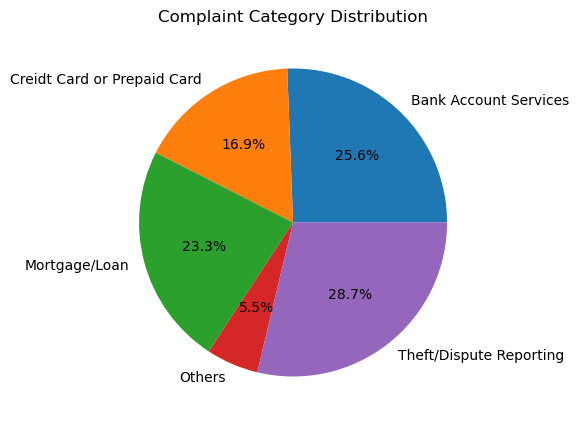

In [61]:
## Visualizing Topic counts using plot.

topic_cnt = df_clean.groupby('Topic').count().iloc[:,0]
plt.figure(figsize=(8,5))
plt.pie(topic_cnt,autopct='%1.1f%%', labels=topic_cnt.index)
plt.title('Complaint Category Distribution')
plt.show()

## Insights from plot:-
### Theft/Dispute Complaint type are major complaints contributing around 28.7% of total complaints received from customer.
### Bank Account Service are secoond highest type of Complaints contributing to 25.6% of total complaints.
### Mortgage/Loan are third highest type of complaints.

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [62]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 'Bank Account Services' : 1,
                'Creidt Card or Prepaid Card' : 2,
                'Mortgage/Loan' : 3,
                'Theft/Dispute Reporting' : 4,
                'Others' : 5
              }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [63]:
df_clean.head(10)

,complaints,lemmatized_complaint,complaint_POS_removed,char_length,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,475,morning name stop service debt verification st...,4
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,337,card agent anniversary date agent information ...,2
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,210,chase card report application identity consent...,4
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,1433,ticket offer ticket reward card information of...,4
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,1
5,can you please remove inquiry,can you please remove inquiry,inquiry,29,inquiry,4
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,2224,notice account debit card branch customer serv...,1
7,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month decline income employment month p...,1350,summer month decline income employment month p...,3
8,on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,payment retailer use chase pay chase website s...,3461,payment retailer use chase pay chase website s...,4
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card report datum credit report c...,127,chase credit card report datum credit report c...,4


In [64]:
#Keeping "complaints"  & "Topic" only in the new dataframe as training_data.
training_data= pd.concat([data_df['complaints'],df_clean['Topic']],axis=1)

In [65]:
training_data.head()

,complaints,Topic
0,good morning my name is xxxx xxxx and i apprec...,4
1,i upgraded my xxxx xxxx card in and was told ...,2
2,chase card was reported on however fraudulent...,4
3,on while trying to book a xxxx xxxx ticket ...,4
4,my grand son give me check for i deposit it i...,1


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [66]:
#Code to get the Vector count of 'complaints' column using Count Vectorizer.

count_vect = CountVectorizer(stop_words='english')   ##Remove stopwords for text preprocessing.
wrd_vector = count_vect.fit_transform(training_data['complaints'])

In [67]:
## importing tf-idf transformer library to transform count vector to tf-idf.
from sklearn.feature_extraction.text import TfidfTransformer

#Code to transform the word count vector to tf-idf

tfidf_transform = TfidfTransformer()
tfidf = tfidf_transform.fit_transform(wrd_vector)
# tfidf_df=pd.DataFrame(tfidf.toarray(), columns=count_vect.get_feature_names_out())
# tfidf_df.head()
## Visualizing top few tfidf words .
vect_100 = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_100 = vect_100.fit_transform(training_data['complaints'])
tfidf_100_df = pd.DataFrame(tfidf_100.toarray(), columns=vect_100.get_feature_names_out())

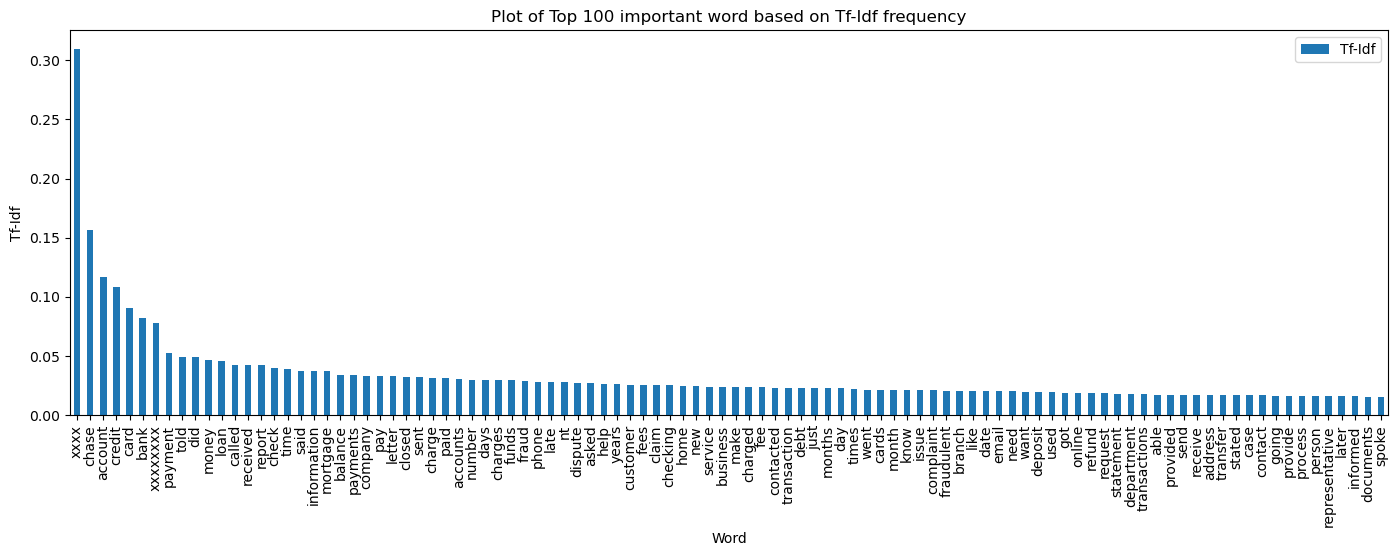

In [68]:
## Finding most important 100 words based on itd tfidf frequency value.
most_imp_word_tfidf = pd.DataFrame(tfidf_100_df.mean().sort_values(ascending=False))
most_imp_word_tfidf.reset_index(inplace=True)
most_imp_word_tfidf.columns=['Word','Tf-Idf']

##Visualizing top 100 important word based on tf-idf frequency.

most_imp_word_tfidf.plot(kind='bar', x='Word', y='Tf-Idf', figsize=(17,5), ylabel='Tf-Idf')
plt.title('Plot of Top 100 important word based on Tf-Idf frequency')
plt.show()

**We can see words 'chase', 'account', 'credit', 'bank', 'payment', 'told' ,'did', 'money', 'loan' are some of few top most imporatnt word.**

In [69]:
## Creating train and test dataset.

X= tfidf ## tfidf is the original tfidf vectorized value of complaints as obtained above.
y= df_clean['Topic']
print(X.shape) ## Total input data dimension is 21072 rows and 33293 features.
print(y.shape) ## Target column is of length 21072(number of complaints)

(21072, 33293)
(21072,)


**Spliitng X and y into train and test by 80-20.**

In [70]:
## Importing libraries.
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, recall_score, precision_score

X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print(X_train.shape)  ## Train data of shape 16857 X 33293
print(X_test.shape)
print(y_train.shape)  ## Test data of shape 4215 X 33293
print(y_test.shape)

(16857, 33293)
(4215, 33293)
(16857,)
(4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Model 1 : Using Logistic Regression model as first basic model.

In [71]:
## Logistic Regression
## importing library

from sklearn.linear_model import LogisticRegression

## Fitting first model.

log_reg = LogisticRegression()
log_reg=log_reg.fit(X_train, y_train)


In [72]:
## Creating Dataframe of Different Model Metrics to compare once we get values from model evlautaion.

model_metrics = pd.DataFrame(np.zeros((6,4)), columns=['Precision','Recall','Accuracy','F1-Score'])
model_metrics=model_metrics.rename(index={0:'Logistic Regression',1:'Decision Tree',2:'Grid Search CV Decision Tree',\
                     3:'Random Forest_10_Depth', 4:'Random Forest_20_Depth', 5:'Grid Search CV Random Forest'})
model_metrics

,Precision,Recall,Accuracy,F1-Score
Logistic Regression,0.0,0.0,0.0,0.0
Decision Tree,0.0,0.0,0.0,0.0
Grid Search CV Decision Tree,0.0,0.0,0.0,0.0
Random Forest_10_Depth,0.0,0.0,0.0,0.0
Random Forest_20_Depth,0.0,0.0,0.0,0.0
Grid Search CV Random Forest,0.0,0.0,0.0,0.0


In [73]:
## Defining function for Evaluation on Train data.

def train_data_evaluate(model,y_train_pred,y_train):
    
    cols = ["Bank Account Services","Creidt Card or Prepaid Card","Mortgage/Loan","Theft/Dispute Reporting","Others"]
    print('Classification Report of Train data prediction:-\n')
    print(classification_report(y_train_pred,y_train, target_names=cols))   ## To get classifictaion report fpr analysis.
    print('f1-score of train data predictions :- ',round(f1_score(y_train_pred,y_train,average='weighted'),2))
    cnf_df=pd.DataFrame(confusion_matrix(y_train_pred,y_train),columns=[cols])
    cnf_df=cnf_df.rename(index={0:"Bank Account Services", 1:"Creidt Card or Prepaid Card", 2:"Mortgage/Loan", 3:"Theft/Dispute Reporting",4:"Others"})
    print('\nConfusion matrix of Train Data:-\n')
    return cnf_df, precision_score(y_train_pred,y_train,average='weighted'), recall_score(y_train_pred,y_train,average='weighted'), accuracy_score(y_train_pred,y_train), \
    f1_score(y_train_pred,y_train,average='weighted')  ## Calculate All scores and return vlaues.
    
    

In [74]:
## Defining function for Evaluation on Test data.

def test_data_evaluate(model,y_test_pred,y_test):
    
    cols = ["Bank Account Services","Creidt Card or Prepaid Card","Mortgage/Loan","Theft/Dispute Reporting","Others"]
    print('Classification Report of Test data prediction:-\n')
    print(classification_report(y_test_pred,y_test, target_names=cols))   ## To get classifictaion report fpr analysis.
    print('f1-score of Test data predictions :- ',round(f1_score(y_test_pred,y_test,average='weighted'),2))
    cnf_df=pd.DataFrame(confusion_matrix(y_test_pred,y_test),columns=[cols])
    cnf_df=cnf_df.rename(index={0:"Bank Account Services", 1:"Creidt Card or Prepaid Card", 2:"Mortgage/Loan", 3:"Theft/Dispute Reporting",4:"Others"})
    print('\nConfusion matrix of Test Data:-\n')
    return cnf_df, precision_score(y_test_pred,y_test,average='weighted'), recall_score(y_test_pred,y_test,average='weighted'), accuracy_score(y_test_pred,y_test), \
    f1_score(y_test_pred,y_test,average='weighted')  ## Calculate All scores and return vlaues.
    
    

In [75]:
## Predicting output of train data.

y_train_pred=log_reg.predict(X_train)

## Evualting model score on training data outcome.

cnf_df_train,prec_scr_train,rec_scr_train,acc_scr_train,f1_scr_train= train_data_evaluate(log_reg,y_train_pred,y_train)  ##calling function to get metrics.
cnf_df_train ## Printing Confusion matrix.

Classification Report of Train data prediction:-

                             precision    recall  f1-score   support

      Bank Account Services       0.94      0.94      0.94      4348
Creidt Card or Prepaid Card       0.93      0.95      0.94      2786
              Mortgage/Loan       0.97      0.96      0.96      3987
    Theft/Dispute Reporting       0.93      0.92      0.92      4899
                     Others       0.87      0.96      0.91       837

                   accuracy                           0.94     16857
                  macro avg       0.93      0.94      0.94     16857
               weighted avg       0.94      0.94      0.94     16857

f1-score of train data predictions :-  0.94

Confusion matrix of Train Data:-



,Bank Account Services,Creidt Card or Prepaid Card,Mortgage/Loan,Theft/Dispute Reporting,Others
Bank Account Services,4074,34,41,162,37
Creidt Card or Prepaid Card,32,2634,20,87,13
Mortgage/Loan,39,6,3832,81,29
Theft/Dispute Reporting,159,144,66,4488,42
Others,8,0,2,21,806


In [76]:
## Predicting output of test data.

y_test_pred=log_reg.predict(X_test)

## Evualting model score on test data.

cnf_df_test,prec_scr_test,rec_scr_test,acc_scr_test,f1_scr_test= test_data_evaluate(log_reg,y_test_pred,y_test)  ##calling function to get metrics.
cnf_df_test ## Printing Confusion matrix.

Classification Report of Test data prediction:-

                             precision    recall  f1-score   support

      Bank Account Services       0.89      0.88      0.89      1086
Creidt Card or Prepaid Card       0.85      0.91      0.88       696
              Mortgage/Loan       0.93      0.93      0.93       942
    Theft/Dispute Reporting       0.90      0.83      0.86      1318
                     Others       0.70      0.92      0.80       173

                   accuracy                           0.88      4215
                  macro avg       0.85      0.89      0.87      4215
               weighted avg       0.89      0.88      0.88      4215

f1-score of Test data predictions :-  0.88

Confusion matrix of Test Data:-



,Bank Account Services,Creidt Card or Prepaid Card,Mortgage/Loan,Theft/Dispute Reporting,Others
Bank Account Services,961,19,19,61,26
Creidt Card or Prepaid Card,18,632,5,27,14
Mortgage/Loan,16,11,875,31,9
Theft/Dispute Reporting,82,84,41,1091,20
Others,6,0,1,6,160


## Observation from Logistic Regression model: 
#### True Positive Rate(Recall) is good for all categories except for class 'Theft/Dispute Reporting' which is 83%'
#### Precision (True Negative Rate) metric is pretty good for all class except for 'Others'.
#### Weighted f1-score of Train data prediction is 94% and weighted f1-score of test data prediction is 88%. There is no huge difference in train and test prediction which indicates model does not overfit train data and hence model is great to begin with.

In [77]:
## Updating model metrics dataframe with values obtained from Loginstic Regression model.

model_metrics.iloc[0,0]=(round(prec_scr_test,2)*100)
model_metrics.iloc[0,1]=(round(rec_scr_test,2)*100)
model_metrics.iloc[0,2]=(round(acc_scr_test,2)*100)
model_metrics.iloc[0,3]=(round(f1_scr_test,2)*100)

In [78]:
model_metrics 

,Precision,Recall,Accuracy,F1-Score
Logistic Regression,89.0,88.0,88.0,88.0
Decision Tree,0.0,0.0,0.0,0.0
Grid Search CV Decision Tree,0.0,0.0,0.0,0.0
Random Forest_10_Depth,0.0,0.0,0.0,0.0
Random Forest_20_Depth,0.0,0.0,0.0,0.0
Grid Search CV Random Forest,0.0,0.0,0.0,0.0


**Let's use Decision Tree as second model for prediction of 'Complaints' category.**

### Model 2 : Using Decision Tree for prediction.

In [79]:
## Importing required libaries.

from sklearn.tree import DecisionTreeClassifier

## instantiate DecisionTreeClassifier with max_depth=5 parameter

dt = DecisionTreeClassifier(max_depth=5, random_state=42) 

## Fitting model

dt=dt.fit(X_train,y_train)

##Checkig parameters
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [80]:
## Predicting output of train data.

y_train_pred_dt=dt.predict(X_train)

## Evualting model score on training data outcome.

cnf_df_train,prec_scr_train,rec_scr_train,acc_scr_train,f1_scr_train= train_data_evaluate(dt,y_train_pred_dt,y_train)  ##calling function to get metrics.
cnf_df_train ## Printing Confusion matrix.


Classification Report of Train data prediction:-

                             precision    recall  f1-score   support

      Bank Account Services       0.68      0.70      0.69      4189
Creidt Card or Prepaid Card       0.73      0.68      0.70      3022
              Mortgage/Loan       0.73      0.82      0.77      3505
    Theft/Dispute Reporting       0.67      0.55      0.61      5885
                     Others       0.23      0.84      0.36       256

                   accuracy                           0.67     16857
                  macro avg       0.61      0.72      0.63     16857
               weighted avg       0.69      0.67      0.68     16857

f1-score of train data predictions :-  0.68

Confusion matrix of Train Data:-



,Bank Account Services,Creidt Card or Prepaid Card,Mortgage/Loan,Theft/Dispute Reporting,Others
Bank Account Services,2951,125,159,793,161
Creidt Card or Prepaid Card,225,2054,151,504,88
Mortgage/Loan,182,62,2890,269,102
Theft/Dispute Reporting,930,569,758,3266,362
Others,24,8,3,7,214


In [81]:
## Predicting output of test data.

y_test_pred_dt=dt.predict(X_test)

## Evualting model score on test data outcome.

cnf_df_test,prec_scr_test,rec_scr_test,acc_scr_test,f1_scr_test= test_data_evaluate(dt,y_test_pred_dt,y_test)  ##calling function to get metrics.
cnf_df_test ## Printing Confusion matrix.


Classification Report of Test data prediction:-

                             precision    recall  f1-score   support

      Bank Account Services       0.66      0.68      0.67      1044
Creidt Card or Prepaid Card       0.72      0.66      0.69       814
              Mortgage/Loan       0.71      0.80      0.75       833
    Theft/Dispute Reporting       0.66      0.54      0.59      1468
                     Others       0.21      0.84      0.33        56

                   accuracy                           0.66      4215
                  macro avg       0.59      0.71      0.61      4215
               weighted avg       0.67      0.66      0.66      4215

f1-score of Test data predictions :-  0.66

Confusion matrix of Test Data:-



,Bank Account Services,Creidt Card or Prepaid Card,Mortgage/Loan,Theft/Dispute Reporting,Others
Bank Account Services,714,39,35,215,41
Creidt Card or Prepaid Card,63,537,45,131,38
Mortgage/Loan,50,12,668,72,31
Theft/Dispute Reporting,252,155,192,797,72
Others,4,3,1,1,47


## Observation from Decision Tree model: 
#### Weighted average Recall score is 66% and weighted average Precision score is 67% which is not so good model.
#### Weighted f1-score of Test data prediction is 66% and weighted f1-score of train data prediction is 68%. 
#### We need to tune hyper-parameter of Decision Tree for better model.

In [82]:
## Updating model metrics dataframe with values obtained from Decision Tree model.

model_metrics.iloc[1,0]=(round(prec_scr_test,2)*100)
model_metrics.iloc[1,1]=(round(rec_scr_test,2)*100)
model_metrics.iloc[1,2]=(round(acc_scr_test,2)*100)
model_metrics.iloc[1,3]=(round(f1_scr_test,2)*100)

In [83]:
model_metrics

,Precision,Recall,Accuracy,F1-Score
Logistic Regression,89.0,88.0,88.0,88.0
Decision Tree,67.0,66.0,66.0,66.0
Grid Search CV Decision Tree,0.0,0.0,0.0,0.0
Random Forest_10_Depth,0.0,0.0,0.0,0.0
Random Forest_20_Depth,0.0,0.0,0.0,0.0
Grid Search CV Random Forest,0.0,0.0,0.0,0.0


### Model 3 : Hyper-parameter tunning of Decision Tree.

In [84]:
## To define paramateres for hyperparameter tunning 

hyp_params = {
          'max_depth':[3,5,10,15,20],
          'min_samples_leaf':[20,50,100,200,400],
           'min_samples_split':[10,50,100],
            }

In [85]:
## Importing Library
from sklearn.model_selection import GridSearchCV

## Grid search cv model 
dt_grid_search_cv = DecisionTreeClassifier(random_state=42)
gs_cv = GridSearchCV(estimator=dt_grid_search_cv, param_grid=hyp_params, n_jobs=-1, verbose=1, cv=5, return_train_score=True)
%time gs_cv=gs_cv.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
CPU times: total: 6.19 s
Wall time: 1min 27s


**Took 1 min 24 sec for Grid Search CV to build model.**

In [86]:
## Checking parameters
gs_cv.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__random_state': 42,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(random_state=42),
 'n_jobs': -1,
 'param_grid': {'max_depth': [3, 5, 10, 15, 20],
  'min_samples_leaf': [20, 50, 100, 200, 400],
  'min_samples_split': [10, 50, 100]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': True,
 'scoring': None,
 'verbose': 1}

In [87]:
## Checking best model estimator

## To get best model estimator 

(gs_cv.best_estimator_).get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 20,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [88]:
## Applying above obtained best paramaters for model prediction.

dt_best = DecisionTreeClassifier(max_depth= 20, min_samples_leaf= 20, min_samples_split= 10, random_state=42)
dt_best = dt_best.fit(X_train,y_train)

In [89]:
## Predicting train data.

y_train_pred_gs=dt_best.predict(X_train)

## Evualting model score on training data outcome.

cnf_df_train,prec_scr_train,rec_scr_train,acc_scr_train,f1_scr_train= train_data_evaluate(dt_best,y_train_pred_gs,y_train)  ##calling function to get metrics.
cnf_df_train ## Printing Confusion matrix.



Classification Report of Train data prediction:-

                             precision    recall  f1-score   support

      Bank Account Services       0.84      0.83      0.83      4359
Creidt Card or Prepaid Card       0.83      0.82      0.82      2828
              Mortgage/Loan       0.89      0.87      0.88      4069
    Theft/Dispute Reporting       0.79      0.80      0.79      4813
                     Others       0.69      0.81      0.75       788

                   accuracy                           0.83     16857
                  macro avg       0.81      0.83      0.82     16857
               weighted avg       0.83      0.83      0.83     16857

f1-score of train data predictions :-  0.83

Confusion matrix of Train Data:-



,Bank Account Services,Creidt Card or Prepaid Card,Mortgage/Loan,Theft/Dispute Reporting,Others
Bank Account Services,3612,71,141,437,98
Creidt Card or Prepaid Card,150,2326,47,268,37
Mortgage/Loan,121,68,3537,260,83
Theft/Dispute Reporting,381,318,215,3832,67
Others,48,35,21,42,642


In [90]:
## Predicting test data.

y_test_pred_gs=dt_best.predict(X_test)

## Evualting model score on training data outcome.

cnf_df_test,prec_scr_test,rec_scr_test,acc_scr_test,f1_scr_test= test_data_evaluate(dt_best,y_test_pred_gs,y_test)  ##calling function to get metrics.
cnf_df_test ## Printing Confusion matrix.



Classification Report of Test data prediction:-

                             precision    recall  f1-score   support

      Bank Account Services       0.79      0.77      0.78      1107
Creidt Card or Prepaid Card       0.80      0.77      0.78       769
              Mortgage/Loan       0.86      0.83      0.85       977
    Theft/Dispute Reporting       0.71      0.73      0.72      1184
                     Others       0.62      0.80      0.70       178

                   accuracy                           0.78      4215
                  macro avg       0.76      0.78      0.77      4215
               weighted avg       0.78      0.78      0.78      4215

f1-score of Test data predictions :-  0.78

Confusion matrix of Test Data:-



,Bank Account Services,Creidt Card or Prepaid Card,Mortgage/Loan,Theft/Dispute Reporting,Others
Bank Account Services,854,35,33,152,33
Creidt Card or Prepaid Card,46,594,23,94,12
Mortgage/Loan,35,13,813,90,26
Theft/Dispute Reporting,136,100,64,869,15
Others,12,4,8,11,143


## Observation from Decision Tree model after tunning hyper parameters: 
#### Both weighted average Recall score and weighted average Precision score are 78% which is far better from Decision Tree model without any parameter tunning.
#### Weighted f1-score of Test data prediction is 76% and weighted f1-score of train data prediction is 83%. 
#### Let's use Randoim Forest for model building.

In [91]:
## Updating model metrics dataframe with values obtained from Decision Tree model.

model_metrics.iloc[2,0]=(round(prec_scr_test,2)*100)
model_metrics.iloc[2,1]=(round(rec_scr_test,2)*100)
model_metrics.iloc[2,2]=(round(acc_scr_test,2)*100)
model_metrics.iloc[2,3]=(round(f1_scr_test,2)*100)

In [92]:
model_metrics

,Precision,Recall,Accuracy,F1-Score
Logistic Regression,89.0,88.0,88.0,88.0
Decision Tree,67.0,66.0,66.0,66.0
Grid Search CV Decision Tree,78.0,78.0,78.0,78.0
Random Forest_10_Depth,0.0,0.0,0.0,0.0
Random Forest_20_Depth,0.0,0.0,0.0,0.0
Grid Search CV Random Forest,0.0,0.0,0.0,0.0


### Model 4 : Using Random Forest for Building model with max_depth=10.

In [93]:
## importing library for Random Forest
from sklearn.ensemble import RandomForestClassifier

## instantiate RandomForestClassifier with n_estimators=100 and max_depth=10.
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  

## Fitting model
rf=rf.fit(X_train,y_train)

##Checkig parameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [94]:
## Predicting train data

y_train_pred_rf=rf.predict(X_train)

## Evualting model score on training data outcome.

cnf_df_train,prec_scr_train,rec_scr_train,acc_scr_train,f1_scr_train= train_data_evaluate(rf,y_train_pred_rf,y_train)  ##calling function to get metrics.
cnf_df_train ## Printing Confusion matrix.

Classification Report of Train data prediction:-

                             precision    recall  f1-score   support

      Bank Account Services       0.80      0.78      0.79      4432
Creidt Card or Prepaid Card       0.16      0.98      0.27       445
              Mortgage/Loan       0.77      0.89      0.83      3417
    Theft/Dispute Reporting       0.92      0.52      0.66      8563
                     Others       0.00      0.00      0.00         0

                   accuracy                           0.67     16857
                  macro avg       0.53      0.63      0.51     16857
               weighted avg       0.84      0.67      0.72     16857

f1-score of train data predictions :-  0.72

Confusion matrix of Train Data:-



,Bank Account Services,Creidt Card or Prepaid Card,Mortgage/Loan,Theft/Dispute Reporting,Others
Bank Account Services,3437,225,193,253,324
Creidt Card or Prepaid Card,0,438,3,0,4
Mortgage/Loan,58,91,3047,134,87
Theft/Dispute Reporting,817,2064,718,4452,512
Others,0,0,0,0,0


In [95]:
## Predicting test data

y_test_pred_rf=rf.predict(X_test)

## Evualting model score on training data outcome.

cnf_df_test,prec_scr_test,rec_scr_test,acc_scr_test,f1_scr_test= test_data_evaluate(rf,y_test_pred_rf,y_test)  ##calling function to get metrics.
cnf_df_test ## Printing Confusion matrix.


Classification Report of Test data prediction:-

                             precision    recall  f1-score   support

      Bank Account Services       0.75      0.72      0.73      1126
Creidt Card or Prepaid Card       0.09      0.97      0.16        66
              Mortgage/Loan       0.72      0.85      0.78       801
    Theft/Dispute Reporting       0.88      0.48      0.62      2222
                     Others       0.00      0.00      0.00         0

                   accuracy                           0.62      4215
                  macro avg       0.49      0.60      0.46      4215
               weighted avg       0.80      0.62      0.67      4215

f1-score of Test data predictions :-  0.67

Confusion matrix of Test Data:-



,Bank Account Services,Creidt Card or Prepaid Card,Mortgage/Loan,Theft/Dispute Reporting,Others
Bank Account Services,808,71,58,99,90
Creidt Card or Prepaid Card,1,64,1,0,0
Mortgage/Loan,18,29,678,53,23
Theft/Dispute Reporting,256,582,204,1064,116
Others,0,0,0,0,0


## Observation:-
#### From basic Random Forest model with only n_estimators=100 and max_depth=10 gives f1-score value as 67% whcih is very low.

In [96]:
## Updating model metrics dataframe with values obtained from Random Forest model.

model_metrics.iloc[3,0]=(round(prec_scr_test,2)*100)
model_metrics.iloc[3,1]=(round(rec_scr_test,2)*100)
model_metrics.iloc[3,2]=(round(acc_scr_test,2)*100)
model_metrics.iloc[3,3]=(round(f1_scr_test,2)*100)

In [97]:
model_metrics

,Precision,Recall,Accuracy,F1-Score
Logistic Regression,89.0,88.0,88.0,88.0
Decision Tree,67.0,66.0,66.0,66.0
Grid Search CV Decision Tree,78.0,78.0,78.0,78.0
Random Forest_10_Depth,80.0,62.0,62.0,67.0
Random Forest_20_Depth,0.0,0.0,0.0,0.0
Grid Search CV Random Forest,0.0,0.0,0.0,0.0


### Model 5 : Using Random Forest for Building model with max_depth=20.

In [98]:
## Lets tune max_width value to 20 and generate second Random Forest model.

rf2 = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)  

## Fitting model
rf2=rf2.fit(X_train,y_train)

##Checkig parameters
rf2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [99]:
## Predicting train data

y_train_pred_rf2=rf2.predict(X_train)

## Evualting model score on training data outcome.

cnf_df_train,prec_scr_train,rec_scr_train,acc_scr_train,f1_scr_train= train_data_evaluate(rf2,y_train_pred_rf2,y_train)  ##calling function to get metrics.
cnf_df_train ## Printing Confusion matrix.

Classification Report of Train data prediction:-

                             precision    recall  f1-score   support

      Bank Account Services       0.91      0.86      0.88      4565
Creidt Card or Prepaid Card       0.63      0.97      0.76      1825
              Mortgage/Loan       0.92      0.94      0.93      3879
    Theft/Dispute Reporting       0.95      0.73      0.83      6360
                     Others       0.25      1.00      0.39       228

                   accuracy                           0.84     16857
                  macro avg       0.73      0.90      0.76     16857
               weighted avg       0.89      0.84      0.85     16857

f1-score of train data predictions :-  0.85

Confusion matrix of Train Data:-



,Bank Account Services,Creidt Card or Prepaid Card,Mortgage/Loan,Theft/Dispute Reporting,Others
Bank Account Services,3906,150,100,154,255
Creidt Card or Prepaid Card,9,1763,2,2,49
Mortgage/Loan,39,27,3646,62,105
Theft/Dispute Reporting,358,878,213,4621,290
Others,0,0,0,0,228


In [100]:
## Predicting test data.

y_test_pred_rf2=rf2.predict(X_test)

## Evualting model score on training data outcome.

cnf_df_test,prec_scr_test,rec_scr_test,acc_scr_test,f1_scr_test= test_data_evaluate(rf2,y_test_pred_rf2,y_test)  ##calling function to get metrics.
cnf_df_test ## Printing Confusion matrix.

Classification Report of Test data prediction:-

                             precision    recall  f1-score   support

      Bank Account Services       0.80      0.71      0.75      1210
Creidt Card or Prepaid Card       0.37      0.86      0.52       323
              Mortgage/Loan       0.83      0.83      0.83       947
    Theft/Dispute Reporting       0.84      0.59      0.69      1728
                     Others       0.03      1.00      0.06         7

                   accuracy                           0.70      4215
                  macro avg       0.57      0.80      0.57      4215
               weighted avg       0.79      0.70      0.73      4215

f1-score of Test data predictions :-  0.73

Confusion matrix of Test Data:-



,Bank Account Services,Creidt Card or Prepaid Card,Mortgage/Loan,Theft/Dispute Reporting,Others
Bank Account Services,863,81,44,123,99
Creidt Card or Prepaid Card,8,277,8,9,21
Mortgage/Loan,32,28,783,67,37
Theft/Dispute Reporting,180,360,106,1017,65
Others,0,0,0,0,7


## Observation:
#### Random Forest model with max_depth=20 gives fi-score 73% which is still better than Random Forest with max_depth=10.
#### Let's use Grid Search CV on Random Forest clasfifer to tune hyperparameter model.

In [101]:
## Updating model metrics dataframe with values obtained from Random Forest model.

model_metrics.iloc[4,0]=(round(prec_scr_test,2)*100)
model_metrics.iloc[4,1]=(round(rec_scr_test,2)*100)
model_metrics.iloc[4,2]=(round(acc_scr_test,2)*100)
model_metrics.iloc[4,3]=(round(f1_scr_test,2)*100)

In [102]:
model_metrics

,Precision,Recall,Accuracy,F1-Score
Logistic Regression,89.0,88.0,88.0,88.0
Decision Tree,67.0,66.0,66.0,66.0
Grid Search CV Decision Tree,78.0,78.0,78.0,78.0
Random Forest_10_Depth,80.0,62.0,62.0,67.0
Random Forest_20_Depth,79.0,70.0,70.0,73.0
Grid Search CV Random Forest,0.0,0.0,0.0,0.0


### Model 6: Grid Search CV of Random Forest Classifier.

In [103]:
## Grid Search CV for hyper parameter tunning of Random Forest classifier.

## Defining paramateres for hyperparameter coarse tunning in Random Forest Classifier.

rf_params = {
          'n_estimators':[10,25,50,80,100,200],
          'max_depth':[3,5,10,15,20,25],
          'min_samples_leaf':[10,20,50,100,200,400],
          'min_samples_split' :[5,10,30,50]
        }

In [104]:
## instantiating Random Forest

rf_grid_search_cv = RandomForestClassifier(random_state=42)

## Grid search cv model 

rf_gs = GridSearchCV(estimator=rf_grid_search_cv, param_grid=rf_params, n_jobs=-1, verbose=1, cv=5, scoring='f1_weighted')
%time rf_gs=rf_gs.fit(X_train,y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
CPU times: total: 47.3 s
Wall time: 21min 31s


**Grid Search CV took around 20 mins 34 sec.**

In [105]:
rf_gs.best_estimator_

RandomForestClassifier(max_depth=25, min_samples_leaf=10, min_samples_split=30,
                       n_estimators=200, random_state=42)

In [106]:
## Applying above obtained best paramaters for model prediction in Random Forest classifier.

rf3 = RandomForestClassifier(n_estimators=200,max_depth= 25, min_samples_leaf= 10, min_samples_split= 30, random_state=42)  

## Fitting model
rf3=rf3.fit(X_train,y_train)

In [107]:
## Predicting train data.

y_train_pred_rf3=rf3.predict(X_train)

## Evualting model score on training data outcome.

cnf_df_train,prec_scr_train,rec_scr_train,acc_scr_train,f1_scr_train= train_data_evaluate(rf3,y_train_pred_rf3,y_train)  ##calling function to get metrics.
cnf_df_train ## Printing Confusion matrix.


Classification Report of Train data prediction:-

                             precision    recall  f1-score   support

      Bank Account Services       0.86      0.76      0.81      4886
Creidt Card or Prepaid Card       0.45      0.90      0.60      1415
              Mortgage/Loan       0.88      0.86      0.87      4085
    Theft/Dispute Reporting       0.87      0.66      0.75      6412
                     Others       0.06      1.00      0.12        59

                   accuracy                           0.76     16857
                  macro avg       0.63      0.84      0.63     16857
               weighted avg       0.83      0.76      0.78     16857

f1-score of train data predictions :-  0.78

Confusion matrix of Train Data:-



,Bank Account Services,Creidt Card or Prepaid Card,Mortgage/Loan,Theft/Dispute Reporting,Others
Bank Account Services,3709,236,188,369,384
Creidt Card or Prepaid Card,27,1278,15,17,78
Mortgage/Loan,91,122,3498,227,147
Theft/Dispute Reporting,485,1182,260,4226,259
Others,0,0,0,0,59


In [108]:
## Predicting test data.

y_test_pred_rf3=rf3.predict(X_test)

## Evualting model score on testing data outcome.

cnf_df_test,prec_scr_test,rec_scr_test,acc_scr_test,f1_scr_test= test_data_evaluate(rf3,y_test_pred_rf3,y_test)  ##calling function to get metrics.
cnf_df_test ## Printing Confusion matrix.

Classification Report of Test data prediction:-

                             precision    recall  f1-score   support

      Bank Account Services       0.81      0.71      0.76      1225
Creidt Card or Prepaid Card       0.38      0.85      0.52       331
              Mortgage/Loan       0.87      0.81      0.84      1005
    Theft/Dispute Reporting       0.82      0.61      0.70      1650
                     Others       0.02      1.00      0.03         4

                   accuracy                           0.71      4215
                  macro avg       0.58      0.80      0.57      4215
               weighted avg       0.79      0.71      0.74      4215

f1-score of Test data predictions :-  0.74

Confusion matrix of Test Data:-



,Bank Account Services,Creidt Card or Prepaid Card,Mortgage/Loan,Theft/Dispute Reporting,Others
Bank Account Services,874,77,42,132,100
Creidt Card or Prepaid Card,6,281,4,13,27
Mortgage/Loan,37,40,817,68,43
Theft/Dispute Reporting,166,348,78,1003,55
Others,0,0,0,0,4


## Observation:-
#### f1-score of test data is 74% and of train data is 78% which is still not so good when compared to Decision Tree and Logistic Regression.

In [109]:
## Updating model metrics dataframe with values obtained from Decision Tree model.

model_metrics.iloc[5,0]=(round(prec_scr_test,2)*100)
model_metrics.iloc[5,1]=(round(rec_scr_test,2)*100)
model_metrics.iloc[5,2]=(round(acc_scr_test,2)*100)
model_metrics.iloc[5,3]=(round(f1_scr_test,2)*100)

**Below is overview of metrics obtained from all above model.**

In [110]:
model_metrics

,Precision,Recall,Accuracy,F1-Score
Logistic Regression,89.0,88.0,88.0,88.0
Decision Tree,67.0,66.0,66.0,66.0
Grid Search CV Decision Tree,78.0,78.0,78.0,78.0
Random Forest_10_Depth,80.0,62.0,62.0,67.0
Random Forest_20_Depth,79.0,70.0,70.0,73.0
Grid Search CV Random Forest,79.0,71.0,71.0,74.0


### Inference from Model Metrics:-
#### 1. Logistic Regression Model shows better prediction in terms of f1-score and Precision score and Recall Score as it is highest among all other models.
#### 2. Random Forest with Grid SEacrh CV =5 folds also gave better model second to Logistic Regression.

# THANK YOU